<a href="https://colab.research.google.com/github/irina-marko/Minimal-metric-dimension/blob/main/GA_Grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import random
from itertools import combinations
from functools import partial
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import time
import re

In [ ]:
def precompute_shortest_paths(G):
  return dict(nx.all_pairs_bellman_ford_path_length(G))


In [ ]:
def is_resolving_set(G, nodes, shortest_paths):
    for u, v in combinations(G.nodes, 2):
        distances_u = [shortest_paths[u][node] for node in nodes]
        distances_v = [shortest_paths[v][node] for node in nodes]

        if not any(dist_u != dist_v for dist_u, dist_v in zip(distances_u, distances_v)):
            return False
    return True

In [ ]:
def fitness(G, nodes, shortest_paths):
    if is_resolving_set(G, nodes, shortest_paths):
        return len(nodes)
    else:
        return float('inf')

In [ ]:
def select_two_parents(population, fitness, iteration, max_iterations):

    if iteration < max_iterations // 2:

        return [tournament_selection(population, fitness, k=3) for _ in range(2)]
    else:

        return [roulette_wheel_selection(population, fitness) for _ in range(2)]

def tournament_selection(population, fitness, k):

    selected = random.sample(list(zip(population, fitness)), k)
    winner = max(selected, key=lambda x: x[1])
    return winner[0]

def roulette_wheel_selection(population, fitness_values):
    # Filter out non-finite fitness values
    finite_population = [(ind, fit) for ind, fit in zip(population, fitness_values) if float('-inf') < fit < float('inf')]

    if not finite_population:
        raise ValueError("No finite fitness values found in population")

    individuals, finite_fitness = zip(*finite_population)
    total_fitness = sum(finite_fitness)

    selection_probs = [fit / total_fitness for fit in finite_fitness]

    return random.choices(individuals, weights=selection_probs, k=2)




In [ ]:
def crossover(parent1, parent2):

    method_choice = random.randint(0, 2)


    set1, set2 = set(parent1), set(parent2)

    if method_choice == 0:

        return list(set1.intersection(set2))
    elif method_choice == 1:

        return list(set1.union(set2))
    else:

        half1 = parent1[:len(parent1)//2]
        half2 = parent2[len(parent2)//2:]
        return half1 + half2


In [ ]:
def mutate(nodes, nodes_list):

    mutation_choice = random.randint(0, 1)

    if mutation_choice == 0:

        if nodes:
            nodes.remove(random.choice(nodes))
        nodes.append(random.choice(nodes_list))
    else:

        if nodes:
            nodes[random.randint(0, len(nodes) - 1)] = random.choice(nodes_list)

    return nodes

In [ ]:
def generate_connected_erdos_renyi(n, p):
    G = nx.erdos_renyi_graph(n, p)
    if nx.is_connected(G):
        return G
    else:

        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [ ]:
def generate_connected_watts_strogatz(n, k, p):
    G = nx.watts_strogatz_graph(n, k, p)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [ ]:
def generate_connected_barabasi_albert(n, m):
    G = nx.barabasi_albert_graph(n, m)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [ ]:
def generate_connected_powerlaw(n, m, p):
    G = nx.powerlaw_cluster_graph(n, m, p)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [ ]:
def generate_connected_random_regular(n, d):
    G = nx.random_regular_graph(d, n)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()

# Example usage:
G_connected_regular = generate_connected_random_regular(100, 5)


In [ ]:
def run_genetic_algorithm_with_params(G, population_size, generations, mutation_rate, selection_strategy, time_limit):

    if not nx.is_connected(G):
        print("Graph is not connected, skipping this graph.")
        return None, None, None

    nodes_list = list(G.nodes)
    shortest_paths = precompute_shortest_paths(G)
    population = [random.sample(nodes_list, random.randint(1, len(nodes_list))) for _ in range(population_size)]

    best_solution = min(population, key=lambda nodes: fitness(G, nodes, shortest_paths))

    start_time = time.time()

    for g in range(generations):

        if (time.time() - start_time) > time_limit:
            print(f"Time limit exceeded in generation {g}, stopping algorithm.")
            break

        print(f"Generation {g} / {generations}, population size: {len(population)}")

        fitness_values = [fitness(G, nodes, shortest_paths) for nodes in population]
        parents = select_two_parents(population, fitness_values, g, generations)

        parent1, parent2 = parents
        child = crossover(parent1, parent2)

        if random.random() < mutation_rate:
            child = mutate(child, nodes_list)

        population.append(child)
        population = sorted(population, key=lambda nodes: fitness(G, nodes, shortest_paths))[:population_size]

        current_best = min(population, key=lambda nodes: fitness(G, nodes, shortest_paths))
        if fitness(G, current_best, shortest_paths) < fitness(G, best_solution, shortest_paths):
            best_solution = current_best


        if (time.time() - start_time) > time_limit:
            print(f"Time limit exceeded after generation {g}, stopping algorithm.")
            break

    elapsed_time = time.time() - start_time
    return best_solution, fitness(G, best_solution, shortest_paths), elapsed_time

In [ ]:
def optimize_parameters(G, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit):

    best_solution_overall = None
    best_fitness_overall = float('inf')
    best_params_overall = None

    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                for selection_strategy in selection_strategies:
                    print(f"Running with population: {population_size}, generations: {generations}, mutation: {mutation_rate}, strategy: {selection_strategy}")


                    best_solution, best_fitness, elapsed_time = run_genetic_algorithm_with_params(
                        G, population_size, generations, mutation_rate, selection_strategy, time_limit
                    )


                    if elapsed_time is None:
                        continue


                    if best_fitness < best_fitness_overall:
                        best_solution_overall = best_solution
                        best_fitness_overall = best_fitness
                        best_params_overall = (population_size, generations, mutation_rate, selection_strategy)


                    print(f"Finished parameters with elapsed time {elapsed_time:.2f} seconds and fitness {best_fitness:.4f}")

    print(f"Best overall parameters: {best_params_overall} with fitness {best_fitness_overall}")
    return best_params_overall, best_solution_overall, best_fitness_overall

In [ ]:
def draw_graph(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()


Erdős-Rényi Random Graph


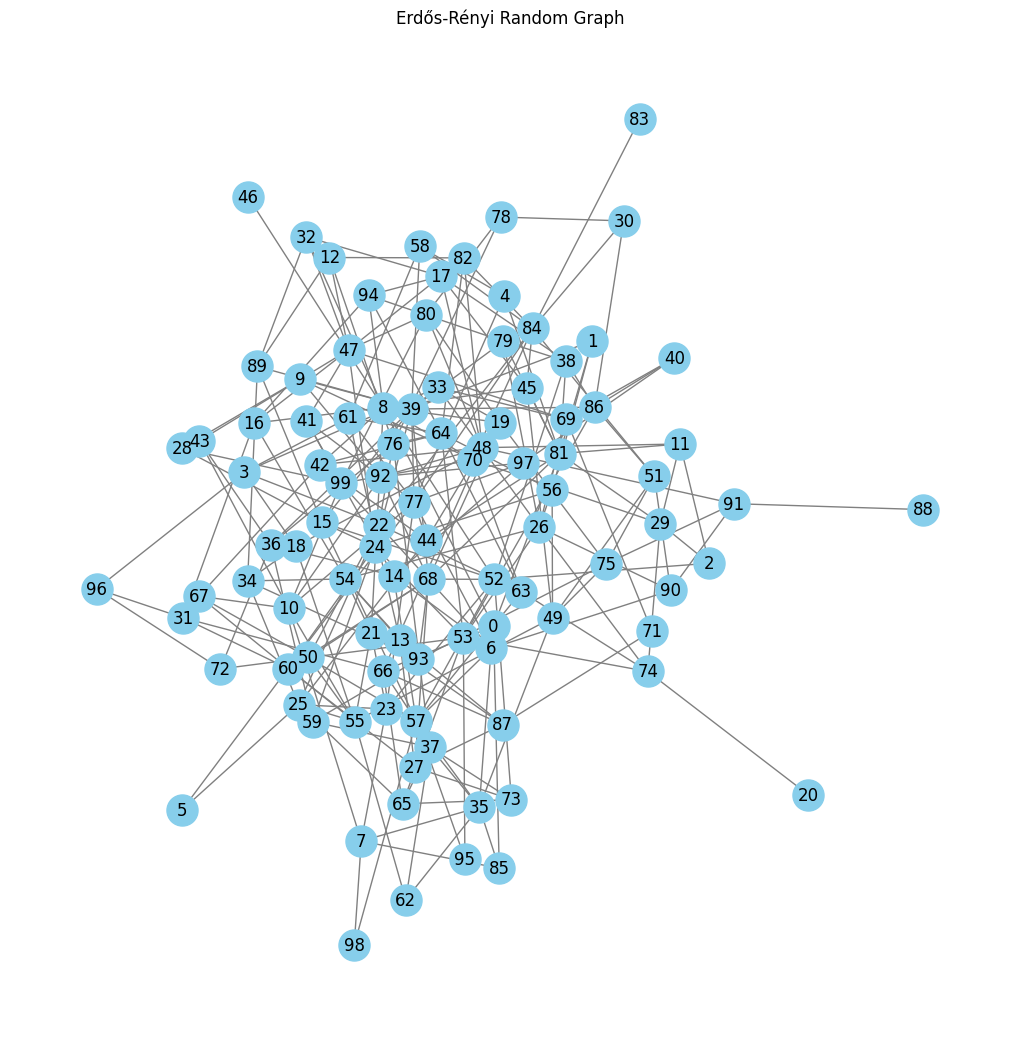

Running with population: 20, generations: 10, mutation: 0.01, strategy: roulette
Generation 0 / 10, population size: 20
Time limit exceeded after generation 0, stopping algorithm.
Finished parameters with elapsed time 14.76 seconds and fitness 14.0000
Running with population: 20, generations: 10, mutation: 0.01, strategy: tournament
Generation 0 / 10, population size: 20
Time limit exceeded after generation 0, stopping algorithm.
Finished parameters with elapsed time 5.26 seconds and fitness 12.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 7.74 seconds and fitness 9.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: tournament
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stoppin

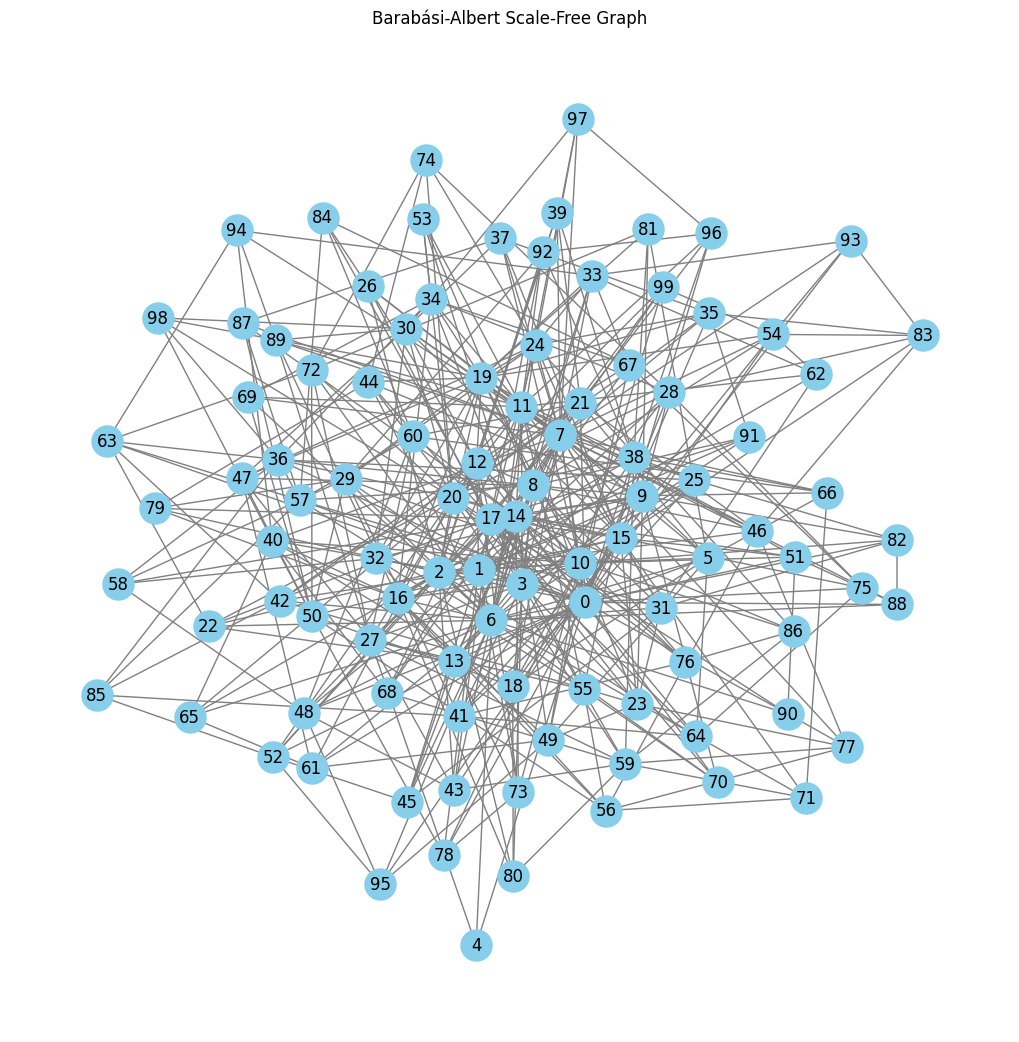

Running with population: 20, generations: 10, mutation: 0.01, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 5.66 seconds and fitness 21.0000
Running with population: 20, generations: 10, mutation: 0.01, strategy: tournament
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 7.18 seconds and fitness 14.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.66 seconds and fitness 18.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: tournament
Generation 0 / 10, population size: 20
Generati

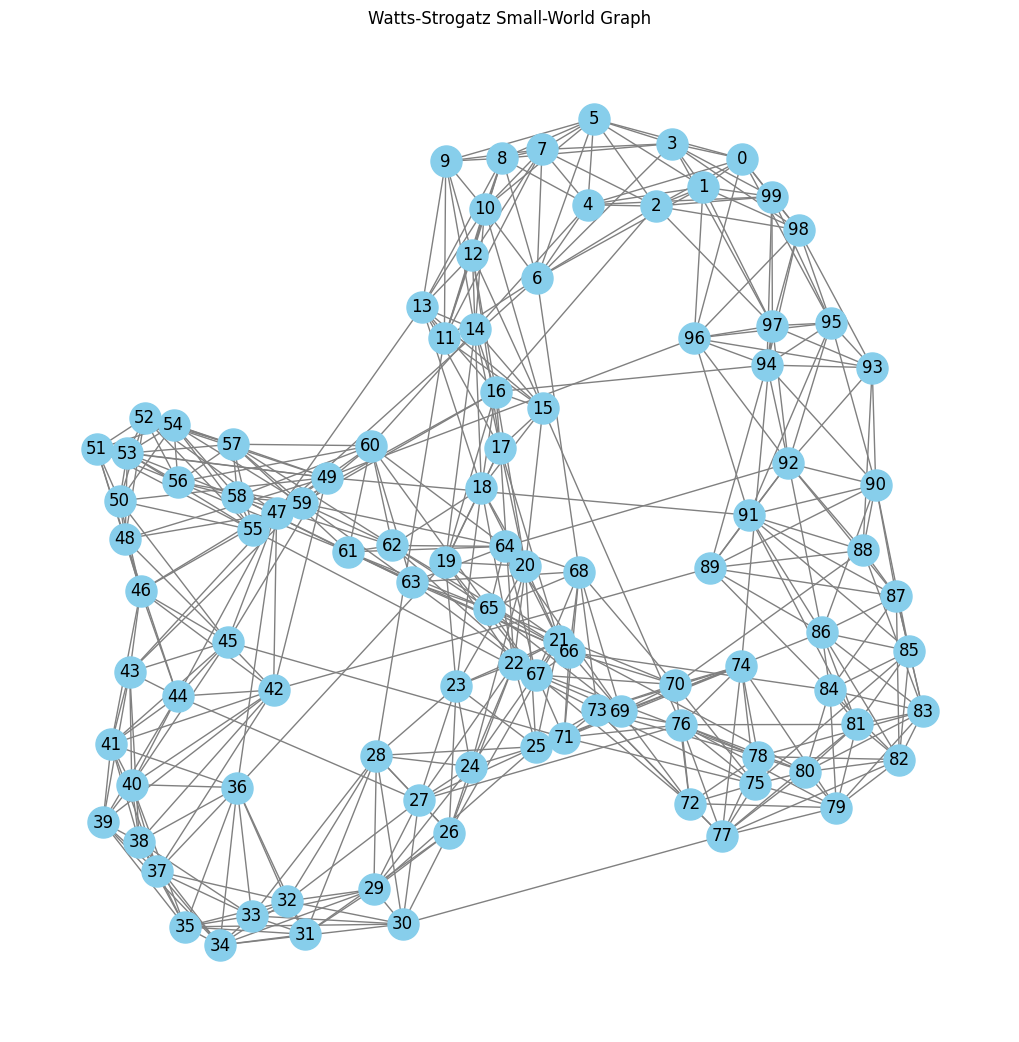

Running with population: 20, generations: 10, mutation: 0.01, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.74 seconds and fitness 30.0000
Running with population: 20, generations: 10, mutation: 0.01, strategy: tournament
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.74 seconds and fitness 22.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.28 seconds and fitness 34.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: tournament
Generation 0 / 10, population size: 20
Generati

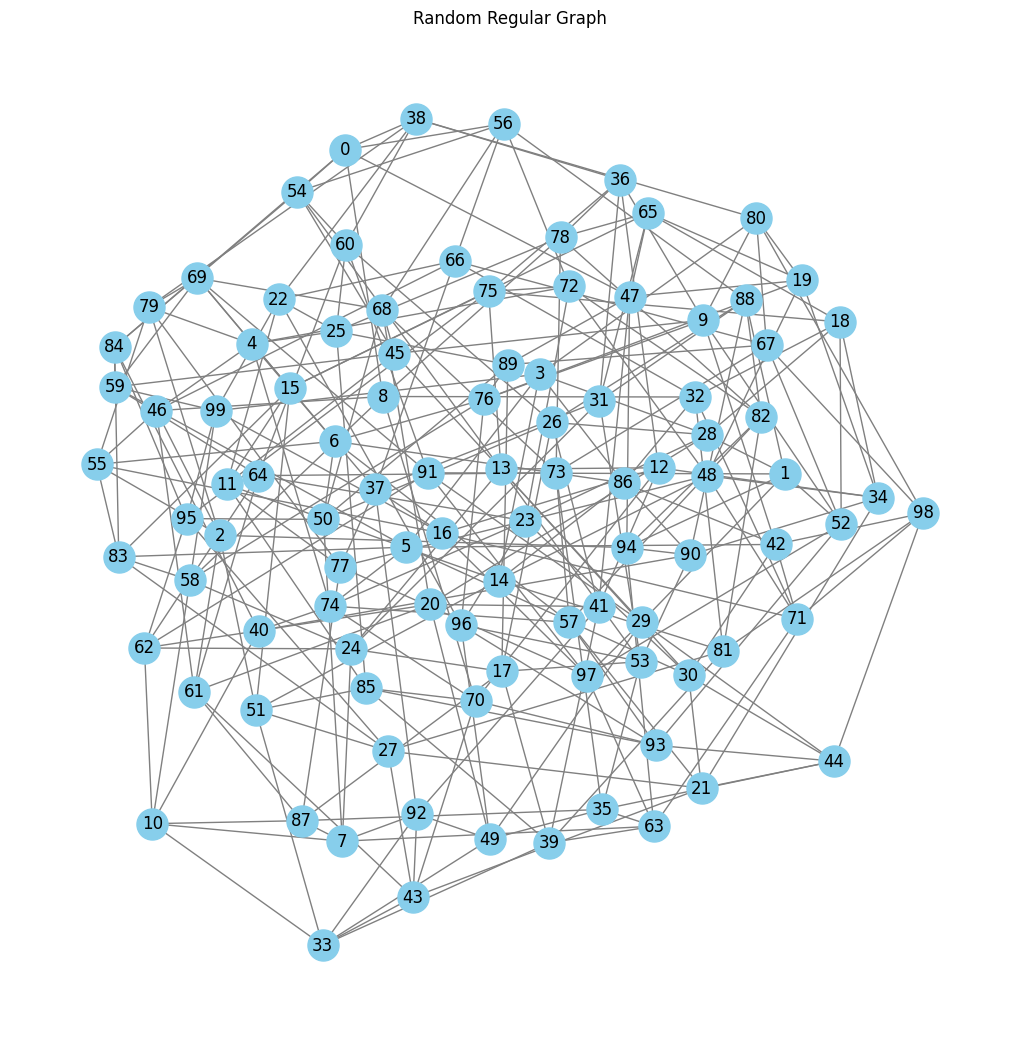

Running with population: 20, generations: 10, mutation: 0.01, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 5.91 seconds and fitness 13.0000
Running with population: 20, generations: 10, mutation: 0.01, strategy: tournament
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.23 seconds and fitness 13.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 6.96 seconds and fitness 20.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: tournament
Generation 0 / 10, population size: 20
Generati

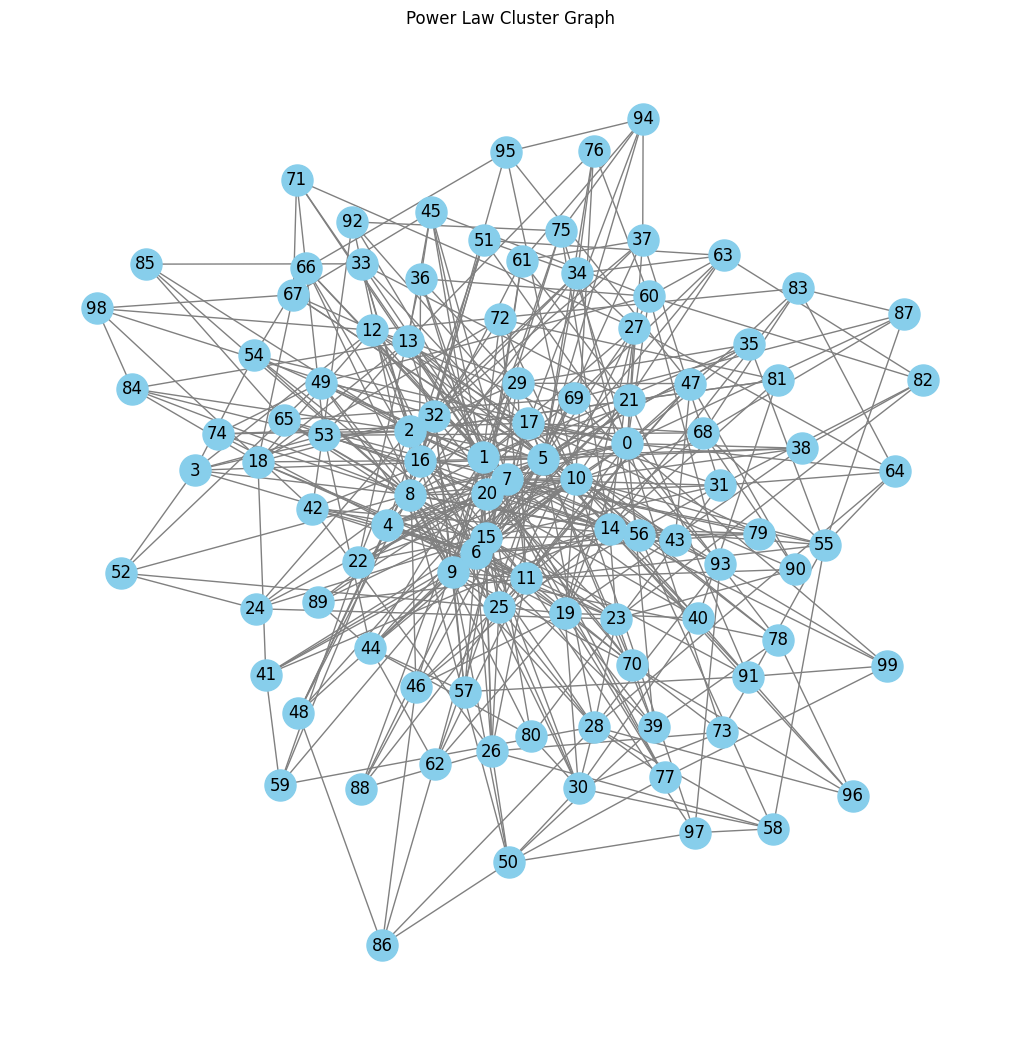

Running with population: 20, generations: 10, mutation: 0.01, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 5.75 seconds and fitness 16.0000
Running with population: 20, generations: 10, mutation: 0.01, strategy: tournament
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 7.78 seconds and fitness 30.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: roulette
Generation 0 / 10, population size: 20
Generation 1 / 10, population size: 20
Time limit exceeded after generation 1, stopping algorithm.
Finished parameters with elapsed time 5.88 seconds and fitness 34.0000
Running with population: 20, generations: 10, mutation: 0.1, strategy: tournament
Generation 0 / 10, population size: 20
Generati

In [ ]:

population_sizes = [20, 50, 100]
generations_list = [10, 20, 100]
mutation_rates = [0.01, 0.1 ,0.05]
selection_strategies = ['roulette', 'tournament']
time_limit = 5.0

# Erdős-Rényi Random Graph
print("\nErdős-Rényi Random Graph")
n = 100
p = 0.05
G_erdos_renyi = generate_connected_erdos_renyi(n,p)
draw_graph(G_erdos_renyi, "Erdős-Rényi Random Graph")
if not nx.is_connected(G_erdos_renyi):
    print("Erdős-Rényi random graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_erdos_renyi, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit)
    print("Best parameters for Erdős-Rényi random graph:", best_parameters)

# Barabási-Albert Scale-Free Graph
print("\nBarabási-Albert Scale-Free Graph")
n = 100
m = 5
G_barabasi_albert = generate_connected_barabasi_albert(n,m)
draw_graph(G_barabasi_albert, "Barabási-Albert Scale-Free Graph")
if not nx.is_connected(G_barabasi_albert):
    print("Barabási-Albert graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_barabasi_albert, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit)
    print("Best parameters for Barabási-Albert scale-free graph:", best_parameters)

# Watts-Strogatz Small-World Graph
print("\nWatts-Strogatz Small-World Graph")
n = 100
k = 10
p = 0.1
G_watts_strogatz = generate_connected_watts_strogatz(n,k,p)
draw_graph(G_watts_strogatz, "Watts-Strogatz Small-World Graph")
if not nx.is_connected(G_watts_strogatz):
    print("Watts-Strogatz graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_watts_strogatz, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit)
    print("Best parameters for Watts-Strogatz small-world graph:", best_parameters)

# Random Regular Graph
print("\nRandom Regular Graph")
n = 100
d = 6
G_random_regular = generate_connected_random_regular(n,d)
draw_graph(G_random_regular, "Random Regular Graph")
if not nx.is_connected(G_random_regular):
    print("Random regular graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_random_regular, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit)
    print("Best parameters for Random regular graph:", best_parameters)

# Power Law Cluster Graph
print("\nPower Law Cluster Graph")
n = 100
m = 5
p = 0.1
G_powerlaw_cluster = generate_connected_powerlaw(n,m,p)
draw_graph(G_powerlaw_cluster, "Power Law Cluster Graph")
if not nx.is_connected(G_powerlaw_cluster):
    print("Power Law Cluster graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_powerlaw_cluster, population_sizes, generations_list, mutation_rates, selection_strategies, time_limit)
    print("Best parameters for Power Law Cluster graph:", best_parameters)
